# An unoffical demo for training MCNN on Shanghai tech dataset (Part-B)

## Imports

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.6/718.6 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 70.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 28.7 MB/s eta 0:00:00


In [ ]:
import scipy
import scipy.io
import cv2

from matplotlib import pyplot as plt

from scipy.ndimage import gaussian_filter

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from PIL import Image

from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning import seed_everything

import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
files.upload() #this will prompt you to upload the kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"navyasingla1309","key":"3ca37827f652b9beed450443fbf65e08"}'}

In [ ]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 71 Apr 21 04:20 kaggle.json


In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d tthien/shanghaitech

100% 332M/333M [00:12<00:00, 30.3MB/s]
100% 333M/333M [00:12<00:00, 27.8MB/s]


In [ ]:
!unzip shanghaitech.zip

Archive:  shanghaitech.zip
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_1.mat  
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_10.mat  
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_100.mat  
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_101.mat  
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_102.mat  
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_103.mat  
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_104.mat  
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_105.mat  
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_106.mat  
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_107.mat  
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_108.mat  
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_109.mat  
  inflating: ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_11.mat  
  inflating: ShanghaiTech/pa

## visualize

In [ ]:
def show(im):
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

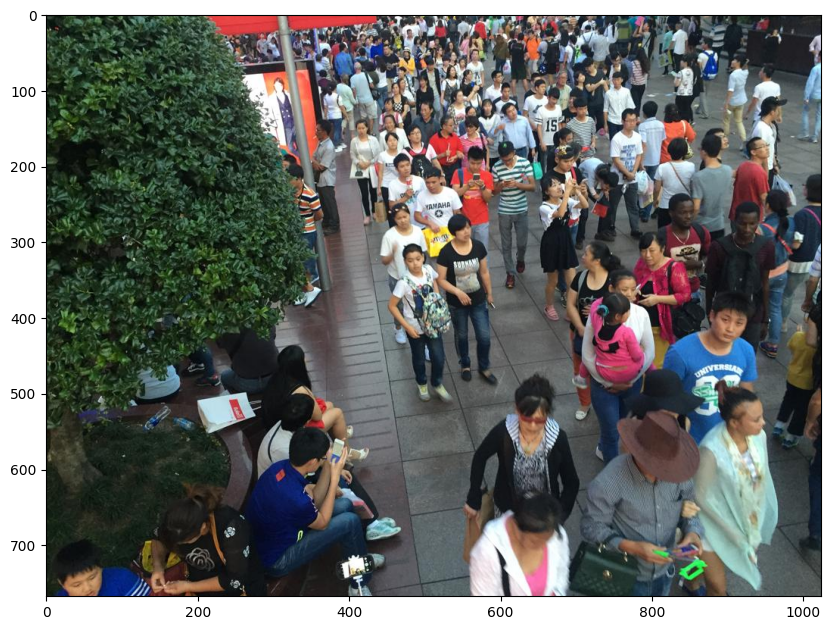

In [ ]:
im = cv2.imread('/content/ShanghaiTech/part_B/train_data/images/IMG_1.jpg', cv2.IMREAD_COLOR)
show(im)

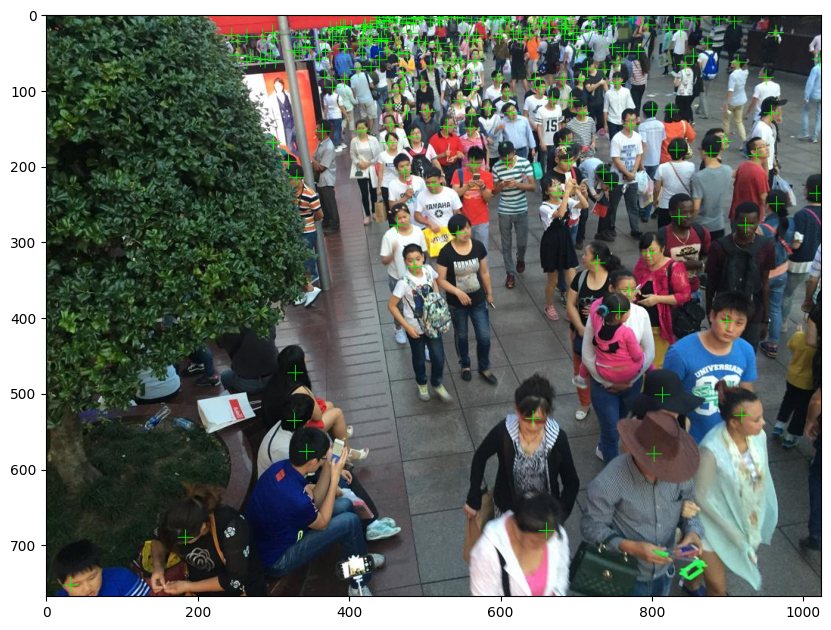

In [ ]:
m = scipy.io.loadmat('/content/ShanghaiTech/part_B/train_data/ground-truth/GT_IMG_1.mat')
ps = m['image_info'][0][0][0][0][0]

for x, y in ps:
    x = int(x)
    y = int(y)
    cv2.drawMarker(im, (x, y), (0, 255, 0))

show(im)

## Prepare dataset

In [ ]:
from sklearn.model_selection import train_test_split

train = [p.path for p in os.scandir('/content/ShanghaiTech/part_B/train_data/images/')]
valid_full = [p.path for p in os.scandir('/content/ShanghaiTech/part_B/test_data/images/')]

## use a small subset for validation
_, valid = train_test_split(valid_full, test_size=64, random_state=42)

len(train), len(valid)

(400, 64)

In [ ]:
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
im_size = 512
aug_train = A.Compose([
    A.RandomCrop(im_size, im_size),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(),
    A.Normalize((0.5), (0.5)),
], keypoint_params=A.KeypointParams(format='xy', angle_in_degrees=False))

aug_val = A.Compose([
    A.Resize(768, 1024),
    A.Normalize((0.5), (0.5)),
], keypoint_params=A.KeypointParams(format='xy', angle_in_degrees=False))

class MyDataset(Dataset):
    def __init__(self, files, aug):
        self.files = files
        self.aug = aug

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fn = self.files[idx]

        im = cv2.imread(fn, cv2.IMREAD_COLOR)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

        m = scipy.io.loadmat(fn.replace('images', 'ground-truth').replace('IMG', 'GT_IMG').replace('.jpg', '.mat'))
        ps = m['image_info'][0][0][0][0][0]

        rst = self.aug(image=im, keypoints=ps)
        im = rst['image']
        ps = rst['keypoints']

        dm = np.zeros((im.shape[0], im.shape[1]), dtype=np.float32)
        for x, y in ps:
            x = int(x)
            y = int(y)
            dm[y, x] = 1

        sigma = 4
        dm = gaussian_filter(dm, sigma=sigma, truncate=4*sigma)

        dm = cv2.resize(dm, (im.shape[1] // 4, im.shape[0] // 4), interpolation=cv2.INTER_LINEAR)
        dm *= 16

        im = torch.from_numpy(im)
        dm = torch.from_numpy(dm)

        return im, dm

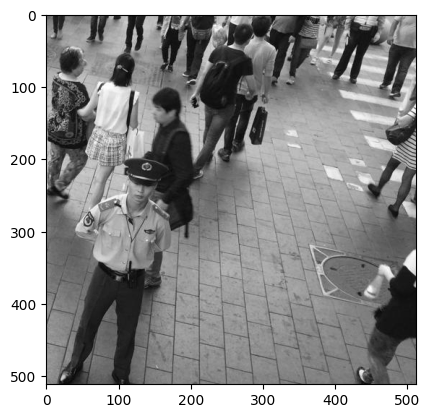

In [ ]:
ds = MyDataset(train, aug_train)
im, dm = ds[0]
plt.imshow(im, cmap='gray')

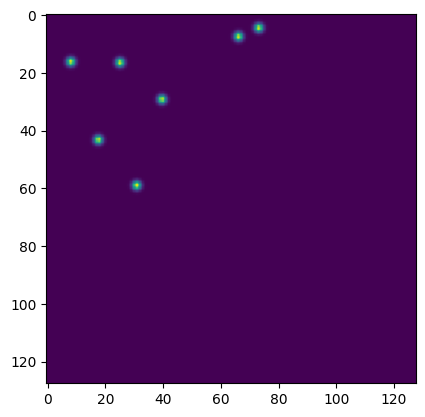

In [ ]:
plt.imshow(dm)

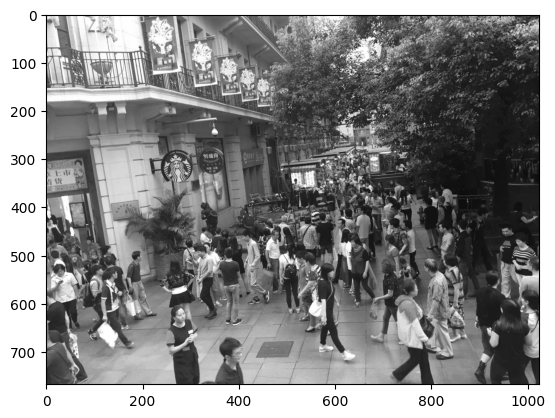

In [ ]:
ds = MyDataset(valid, aug_val)
im, dm = ds[0]
plt.imshow(im, cmap='gray')

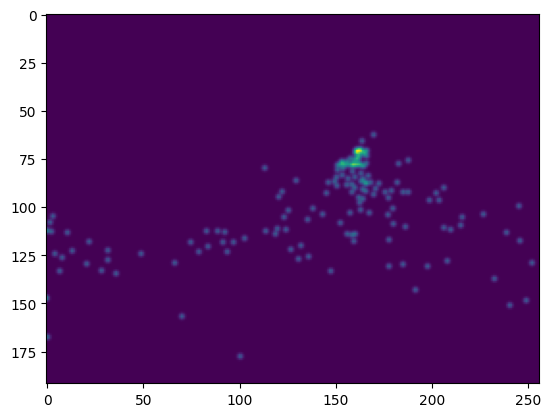

In [ ]:
plt.imshow(dm)

In [ ]:
dm.sum()

tensor(156.)

## Building Model

In [ ]:
class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, relu=True, same_padding=False, bn=False):
        super(Conv2d, self).__init__()
        padding = int((kernel_size - 1) / 2) if same_padding else 0
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0, affine=True) if bn else None
        self.relu = nn.ReLU(inplace=True) if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x


In [ ]:
class MCNN(LightningModule):
    '''
    Multi-column CNN
        -Implementation of Single Image Crowd Counting via Multi-column CNN (Zhang et al.)
    '''

    def __init__(self, lr, batch_size, max_steps, bn=False):
        super(MCNN, self).__init__()

        self.lr = lr
        self.save_hyperparameters()

        self.use = 0

        self.branch1 = nn.Sequential(Conv2d( 1, 16, 9, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(16, 32, 7, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(32, 16, 7, same_padding=True, bn=bn),
                                     Conv2d(16,  8, 7, same_padding=True, bn=bn))

        self.branch2 = nn.Sequential(Conv2d( 1, 20, 7, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(20, 40, 5, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(40, 20, 5, same_padding=True, bn=bn),
                                     Conv2d(20, 10, 5, same_padding=True, bn=bn))

        self.branch3 = nn.Sequential(Conv2d( 1, 24, 5, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(24, 48, 3, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(48, 24, 3, same_padding=True, bn=bn),
                                     Conv2d(24, 12, 3, same_padding=True, bn=bn))

        self.fuse = nn.Sequential(Conv2d( 30, 1, 1, same_padding=True, bn=bn))

        self.out1 = nn.Sequential(Conv2d( 8, 1, 1, same_padding=True, bn=bn))
        self.out2 = nn.Sequential(Conv2d( 10, 1, 1, same_padding=True, bn=bn))
        self.out3 = nn.Sequential(Conv2d( 12, 1, 1, same_padding=True, bn=bn))

        self.crit = nn.MSELoss()

    def forward(self, im_data):
        im_data = im_data.unsqueeze(1)
        x1 = self.branch1(im_data)
        x2 = self.branch2(im_data)
        x3 = self.branch3(im_data)


        if self.use == 0:
            x = torch.cat((x1,x2,x3),1)
            x = self.fuse(x)
        elif self.use == 1:
            x = self.out1(x1)
        elif self.use == 2:
            x = self.out2(x2)
        elif self.use == 3:
            x = self.out3(x3)

        return x.squeeze(1)


    def training_step(self, batch, batch_idx):
        self.train()
        x, y = batch

        pred = self(x)
        loss = self.crit(pred, y)

        pred_sum = torch.round(pred.sum(dim=(1,2))).int()
        gt_sum = torch.round(y.sum(dim=(1,2))).int()
        acc = (pred_sum == gt_sum).float().mean()

        mae = torch.abs(pred_sum - gt_sum).float().mean()

        self.log('train_loss', loss)
        self.log('train_acc', acc)
        self.log('train_mae', mae)

        return loss

    def validation_step(self, batch, batch_idx):
        with torch.no_grad():
            self.eval()
            x, y = batch

            pred = self(x)
            loss = self.crit(pred, y)

            pred_sum = torch.round(pred.sum(dim=(1,2))).int()
            gt_sum = torch.round(y.sum(dim=(1,2))).int()
            acc = (pred_sum == gt_sum).float().mean()

            mae = torch.abs(pred_sum - gt_sum).float().mean()

            self.log('val_loss', loss)
            self.log('val_acc', acc)
            self.log('val_mae', mae)


    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=1e-4)

        scheduler = {
            'scheduler': torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=self.lr, total_steps=self.hparams.max_steps, pct_start=0.1, cycle_momentum=False),
            'interval': 'step',
            'frequency': 1
        }

        return [optimizer], [scheduler]

### weight init is crucial for the model to converge

In [ ]:
def weights_normal_init(model, dev=0.01):
    if isinstance(model, list):
        for m in model:
            weights_normal_init(m, dev)
    else:
        for n, m in model.named_modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0.0, dev)
                if m.bias is not None:
                    m.bias.data.fill_(0.0)
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0.0, dev)

## Training

In [ ]:
batch_size = 32
epochs = 300
max_steps = epochs * len(train) // batch_size

In [ ]:
train_loader = DataLoader(MyDataset(train, aug_train), batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = DataLoader(MyDataset(valid, aug_val), batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=4)

### training

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
seed_everything(42)

checkpoint_cb = ModelCheckpoint(
    save_top_k=1,
    save_last=True,
    verbose=True,
    monitor='val_mae',
    mode='min'
)

trainer = Trainer(max_steps=max_steps, precision=16, benchmark=True, callbacks=[checkpoint_cb, LearningRateMonitor()])

lr = 3e-4

model = MCNN(lr, batch_size, max_steps)
weights_normal_init(model, dev=0.01)

model.use = 0

trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type       | Params
---------------------------------------
0 | branch1 | Sequential | 57.8 K
1 | branch2 | Sequential | 46.1 K
2 | branch3 | Sequential | 24.0 K
3 | fuse    | Sequential | 31    
4 | out1    | Sequential | 9     
5 | out2    | Sequential | 11    
6 | out3    | Sequential | 13    
7 | crit    | MSELoss    | 0     
---------------------------------------
127 K     Tra

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 12: 'val_mae' reached 113.59375 (best 113.59375), saving model to '/content/lightning_logs/version_4/checkpoints/epoch=0-step=12.ckpt' as top 1


In [ ]:
import pytorch_lightning as pl

class MetricHistoryLogger(pl.Callback):
    def __init__(self):
        super().__init__()
        self.metric_history = {'train_loss': [], 'val_loss': []}

    def on_epoch_end(self, trainer, pl_module):
        self.metric_history['train_loss'].append(trainer.callback_metrics['train_loss'])
        self.metric_history['val_loss'].append(trainer.callback_metrics['val_loss'])
history_logger = MetricHistoryLogger()
trainer = Trainer(max_steps=max_steps*2, precision=16, benchmark=True, callbacks=[checkpoint_cb, LearningRateMonitor(), history_logger])

lr = 3e-4
model = MCNN(lr, batch_size, max_steps*2)
weights_normal_init(model, dev=0.01)

model.use = 0
#model = MCNN(lr, batch_size, max_steps)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

/usr/local/lib/python3.9/dist-packages/lightning_fabric/connector.py:562: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /content/lightning_logs/version_4/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorc

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 12: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 24: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 36: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 48: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 60: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 72: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 84: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 96: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 108: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 120: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 132: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 144: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 156: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 168: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 180: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 192: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 204: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 216: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 228: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 240: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 20, global step 252: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 21, global step 264: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 22, global step 276: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 23, global step 288: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 24, global step 300: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 25, global step 312: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 26, global step 324: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 27, global step 336: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 28, global step 348: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 29, global step 360: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 30, global step 372: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 31, global step 384: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 32, global step 396: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 33, global step 408: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 34, global step 420: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 35, global step 432: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 36, global step 444: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 37, global step 456: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 38, global step 468: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 39, global step 480: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 40, global step 492: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 41, global step 504: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 42, global step 516: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 43, global step 528: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 44, global step 540: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 45, global step 552: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 46, global step 564: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 47, global step 576: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 48, global step 588: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 49, global step 600: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 50, global step 612: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 51, global step 624: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 52, global step 636: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 53, global step 648: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 54, global step 660: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 55, global step 672: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 56, global step 684: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 57, global step 696: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 58, global step 708: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 59, global step 720: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 60, global step 732: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 61, global step 744: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 62, global step 756: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 63, global step 768: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 64, global step 780: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 65, global step 792: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 66, global step 804: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 67, global step 816: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 68, global step 828: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 69, global step 840: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 70, global step 852: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 71, global step 864: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 72, global step 876: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 73, global step 888: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 74, global step 900: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 75, global step 912: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 76, global step 924: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 77, global step 936: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 78, global step 948: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 79, global step 960: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 80, global step 972: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 81, global step 984: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 82, global step 996: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 83, global step 1008: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 84, global step 1020: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 85, global step 1032: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 86, global step 1044: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 87, global step 1056: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 88, global step 1068: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 89, global step 1080: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 90, global step 1092: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 91, global step 1104: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 92, global step 1116: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 93, global step 1128: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 94, global step 1140: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 95, global step 1152: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 96, global step 1164: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 97, global step 1176: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 98, global step 1188: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 99, global step 1200: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 100, global step 1212: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 101, global step 1224: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 102, global step 1236: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 103, global step 1248: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 104, global step 1260: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 105, global step 1272: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 106, global step 1284: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 107, global step 1296: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 108, global step 1308: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 109, global step 1320: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 110, global step 1332: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 111, global step 1344: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 112, global step 1356: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 113, global step 1368: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 114, global step 1380: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 115, global step 1392: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 116, global step 1404: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 117, global step 1416: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 118, global step 1428: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 119, global step 1440: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 120, global step 1452: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 121, global step 1464: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 122, global step 1476: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 123, global step 1488: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 124, global step 1500: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 125, global step 1512: 'val_mae' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 126, global step 1524: 'val_mae' was not in top 1
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


## Visualize the result
We can see that the recognition results highlight the human body

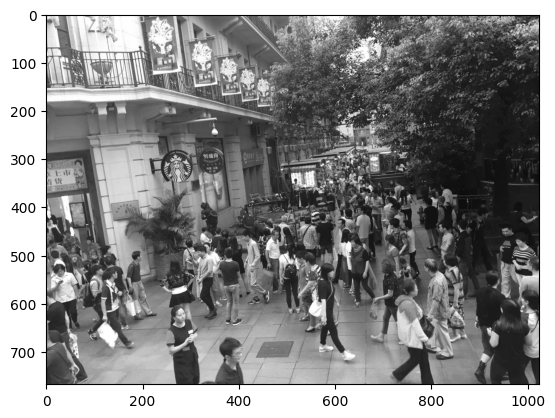

In [ ]:
ds = MyDataset(valid, aug_val)
d = ds[0][0]
plt.imshow(d, cmap='gray')

In [ ]:
plt.imshow(model(d.unsqueeze(0)).detach()[0])

In [ ]:
model(d.unsqueeze(0)).detach()[0].sum()

In [ ]:
for metric_name, metric_value in trainer.logged_metrics.items():
    print(f"{metric_name}: {metric_value}")


train_loss: 6.957251753192395e-05
train_acc: 0.03125
train_mae: 4.8125
val_loss: 0.0001479176280554384
val_acc: 0.03125
val_mae: 25.671875


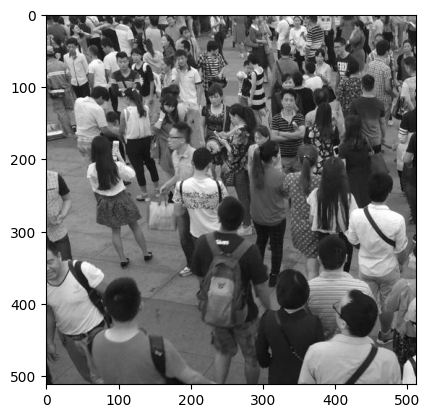

In [ ]:
ds = MyDataset(train, aug_train)
d = ds[122][0]
plt.imshow(d, cmap='gray')

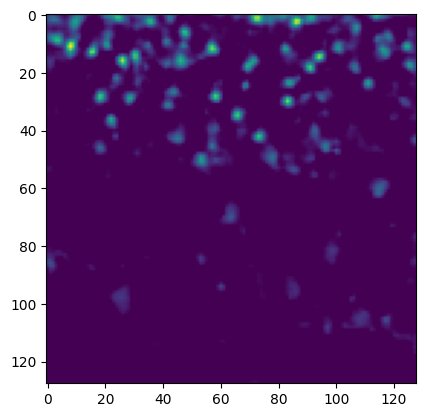

In [ ]:
plt.imshow(model(d.unsqueeze(0)).detach()[0])

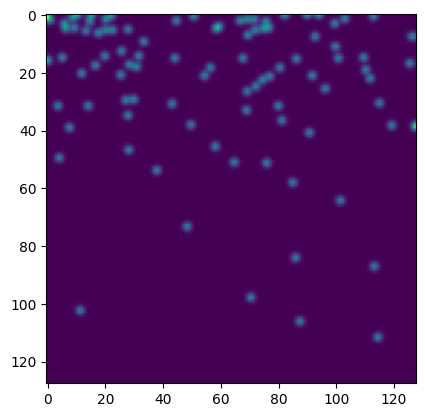

In [ ]:
ds = MyDataset(train, aug_train)
d = ds[122][1]
plt.imshow(d)